#### 整体结构

Affine-ReLU连接被替换成了Convolution-ReLU-Pooling连接

#### 卷积层和池化层的实现

im2col函数的实现
im2col(input_data, filter_h, filter_w, stride=1, pad=0)
input_data: 输入数据，形状为(N, C, H, W)
filter_h: 滤波器的高
filter_w: 滤波器的宽
stride: 步长，默认为1
pad: 填充，默认为0



In [2]:
import numpy as np
import sys,os 
sys.path.append(os.getcwd())
sys.path.append(os.pardir)
from common.util import im2col

x1 = np.random.rand(1, 3, 7, 7)
coll = im2col(x1, 5, 5, stride=1, pad=0)
print(coll.shape)

x2 = np.random.rand(10, 3, 7, 7)
coll = im2col(x2, 5, 5, stride=1, pad=0)
print(coll.shape)


(9, 75)
(90, 75)


In [ ]:
class Convolution:
    def __init__(self, W, b, stride=1, pad=0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad
        
    def forward(self, x):
        FN, C, FH, FW = self.W.shape
        N, C, H, W = x.shape
        out_h = int((H + 2*self.pad - FH) / self.stride) + 1
        out_w = int((W + 2*self.pad - FW) / self.stride) + 1
        
        col = im2col(x, FH, FW, self.stride, self.pad)
        col_W = self.W.reshape(FN, -1).T #滤波器展开
        out = np.dot(col, col_W) + self.b
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)
        
        return out

In [ ]:
class Pooling:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad
        
    def forward(self, x):
        N, C, H, W = x.shape
        out_h = int((H + 2 * self.pad - self.pool_h) / self.stride + 1)
        out_w = int((W + 2 * self.pad - self.pool_w) / self.stride + 1)
        
        #展开（1）
        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h * self.pool_w)
        
        #最大值（2）
        out = np.max(col, axis=1)
        #转换（3）
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)
        
        return out

#### CNN的实现

网络构成为Convolution - ReLU -Pooling - Affine - ReLU - Affine - Softmax

In [3]:
class SimpleConvNet:
    def __init__(self, input_dim=(1, 28, 28),
                 conv_param={'filter_num':30, 'filter_size':5, 'pad':0,'stride':1},
                 hidden_size=100, output_size=10, weight_init_std=0.01):
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2*filter_pad) / filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size/2) * (conv_output_size/2))
        
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        
        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'],
                                           conv_param['stride'], conv_param['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])
        self.last_layer = SoftmaxWithLoss()
        
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        return x
        
    def loss(self, x, t):
        y = self.predict(x)
        return self.last_layer.forward(y, t)
    
    def gradient(self, x, t):
        #forward
        self.loss(x, t)
        
        #backward
        dout = 1
        dout = self.last_layer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)
        
        #设定
        grads = {}
        grads['W1'] = self.layers['Conv1'].dW
        grads['b1'] = self.layers['Conv1'].db
        grads['W2'] = self.layers['Affine1'].dW
        grads['b2'] = self.layers['Affine1'].db
        grads['W3'] = self.layers['Affine2'].dW
        grads['b3'] = self.layers['Affine2'].db
        
        return grads
        

train loss:2.299347510078876
=== epoch:1, train acc:0.171, test acc:0.159 ===
train loss:2.2968792167063437
train loss:2.2888812859721814
train loss:2.2862953406263924
train loss:2.278695006010523
train loss:2.269253139432814
train loss:2.247427024402728
train loss:2.232706783286117
train loss:2.2057442915827936
train loss:2.1809729131811064
train loss:2.1351386514620496
train loss:2.103354197898726
train loss:2.05508002209125
train loss:2.025501997260418
train loss:1.9569845894440454
train loss:1.8808196942919542
train loss:1.8019317726861181
train loss:1.73509225252134
train loss:1.68022795551911
train loss:1.532165730393816
train loss:1.4006710511922664
train loss:1.3435962233879264
train loss:1.2920070441104208
train loss:1.2169794784371302
train loss:1.2235227879648347
train loss:1.0090386444566806
train loss:0.9979721067732406
train loss:0.9900642848577728
train loss:0.9063232773520898
train loss:0.7801226715230202
train loss:0.9107348673232049
train loss:0.8387065492188346
train

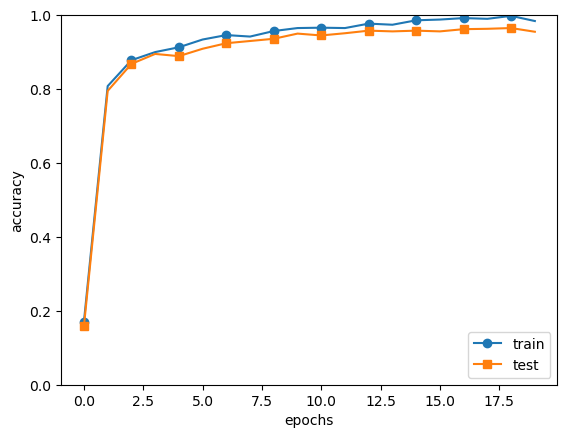

In [5]:
# coding: utf-8
import sys, os
sys.path.append(os.getcwd())
sys.path.append(os.pardir)  # 为了导入父目录的文件而进行的设定
import numpy as np
import matplotlib.pyplot as plt
from simple_convnet import SimpleConvNet
from dataset.mnist import load_mnist
from common.trainer import Trainer

# 读入数据
(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

# 处理花费时间较长的情况下减少数据 
x_train, t_train = x_train[:5000], t_train[:5000]
x_test, t_test = x_test[:1000], t_test[:1000]

max_epochs = 20

network = SimpleConvNet(input_dim=(1,28,28), 
                        conv_param = {'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)
                        
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='Adam', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)
trainer.train()

# 保存参数
network.save_params("params.pkl")
print("Saved Network Parameters!")

# 绘制图形
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, trainer.train_acc_list, marker='o', label='train', markevery=2)
plt.plot(x, trainer.test_acc_list, marker='s', label='test', markevery=2)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()
